In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

In [2]:
method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial Parameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure Competency", 
                           "real_early": "Real early Param.",
                           "real_parameters": "Real Param."}


def parameter_table_model(df, latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3,
                            methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[sub_df["method"].isin(methods)]
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    rmse_columns = ["method", "sample_size", "rmse_early_A", "rmse_early_delta", "rmse_early_sigma",
                    "rmse_late_A", "rmse_late_delta", "rmse_late_sigma", "rmse_psi"]
    sub_df = sub_df[rmse_columns]
    columns = ["Method","Sample size", "$A^e$", "$\Delta^e$", "$\Sigma^e$",
                       "$A^l$", "$\Delta^l$", "$\Sigma^l$", "$\Psi$"]
    sub_df.columns = columns
    sub_df = sub_df.replace(method_replacement_dict)
    parameter_table = sub_df.groupby(["Sample size", "Method"]).agg(aggfunc)
    parameter_table = np.round(parameter_table, decimals)
    #parameter_table.columns = pd.MultiIndex.from_product([["RMSE"], parameter_table.columns], names=['Metric', ''])
    
    #columns = list(zip(["RMSE" for i in range(0, len(columns))],parameter_table.columns))
    #parameter_table.columns = columns
    print(parameter_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", $n={0}$".format(n), 
                                   position="H", escape=False))
    return(parameter_table)
    

In [3]:
# Make one combined Model-fit table for all Q-Matrices
def likelihood_table_model(df_list, Q_names=["Full", "Seperated", "Pyramid"], 
                            latent_dimension=2, item_dimension=20,
                             aggfunc="median", caption="", decimals=3):
    combined_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        df = df[(df["item_dimension"] == item_dimension) & (df["latent_dimension"] == latent_dimension)]
        q_df_early = df[["early_l_estimated", "method", "sample_size"]]
        
        q_df_early.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_early.loc[:,"Model"] = "Early"
        q_df_late = df[["late_l_estimated", "method", "sample_size"]]
        q_df_late.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_late.loc[:,"Model"] = "Late"
        q_df = pd.concat((q_df_early, q_df_late), axis=0)
        q_df["Q-type"] = Q_names[i]
        combined_df = pd.concat((combined_df, q_df), axis=0)
    combined_df = combined_df.replace(method_replacement_dict)
    combined_df = np.round(combined_df, 0)
    fit_table = pd.crosstab(index=[combined_df["N"], combined_df["Method"]], 
                            columns=[combined_df["Model"], combined_df["Q-type"]],
                            values=combined_df["Marginal Log-Likelihood"],
                            aggfunc=aggfunc)
    n = np.min(combined_df.groupby(["Model", "Q-type", "N"])["Method"].value_counts())
    print(fit_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", $n={0}$".format(n), 
                                   position="H", escape=False))
    return(fit_table)

# TODO: Maybe include empirical likelihood not only marginal?

In [4]:
def single_metric_table(df, metric, aggfunc="median", latex=True, decimals=3, caption="",
                        methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    df = df[df["method"].isin(methods)]
    df = df.replace(method_replacement_dict)
    n = np.min(df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    df = df.rename(columns={"method": "Method", "latent_dimension": "Latent Dimension", "item_dimension": "Item Dimension", "sample_size": "N"})
    table = pd.crosstab(index=[df["N"], df["Method"]],
                columns=[df["Latent Dimension"], df["Item Dimension"]], 
                values=df[metric], 
                aggfunc=aggfunc)
    table = np.round(table, decimals)
    if latex:
        print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,
                             caption=caption+", $n={0}$".format(n),
                             position="H"))
    return(table)

In [5]:
def model_boxplot(df, metric='rmse_psi', latent_dimension=2, item_dimension=20, 
                  title="",
                  methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[(sub_df["method"].isin(methods))]
    sub_df = sub_df.replace(method_replacement_dict)
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    fig = plt.gcf()
    fig.set_dpi(100)
    fig.set_size_inches(10, 5)
    plt.title(title+" n={0}".format(n))
    sn.boxplot(x=sub_df[metric], hue=sub_df["sample_size"].astype("str"), y=sub_df["method"],
               orient="h")

# Results

In [6]:
full_Q_df = pd.read_csv("results/full_q.csv")
print("Full Q sample size: {0}".format(full_Q_df.shape[0]))
sep_Q_df = pd.read_csv("results/seperated_q.csv")
print("Seperated Q sample size: {0}".format(sep_Q_df.shape[0]))
pyramid_Q_df = pd.read_csv("results/pyramid_q.csv")
print("Pyramid Q sample size: {0}".format(pyramid_Q_df.shape[0]))

Full Q sample size: 4746
Seperated Q sample size: 4296
Pyramid Q sample size: 3510


## Simulatuion Results

### Model Fit

In [7]:
single_metric_table(full_Q_df, metric="late_l_estimated")

\begin{table}[H]
\centering
\caption{, $n=26$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &        10 &        20 &       30 &        10 &        20 &        30 \\
\textbf{N} & \textbf{Method} &           &           &          &           &           &           \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  -187.320 &  -288.170 &  -402.28 &  -215.550 &  -317.155 &  -430.570 \\
    & \textbf{Initial Parameters} &  -235.530 &  -387.590 &  -525.68 &  -289.075 &  -457.485 &  -622.640 \\
    & \textbf{Late EM} &  -182.100 &  -288.505 &  -401.53 &  -199.845 &  -311.200 &  -429.030 \\
    & \textbf{Pure Competency} &  -184.185 &  -288.870 &  -400.99 &  -209.280 &  -310.125 &  -426.630 \\
    & \textbf{Real early Param.} &  -191.045 &  -294.690 &  -403.04 &  -223.550 &  -317.295 &  -430.400 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  -679.595 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3054108605.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension               2                            3            \
Item Dimension                10        20       30        10        20   
N   Method                                                                
30  Difference          -187.320  -288.170  -402.28  -215.550  -317.155   
    Initial Parameters  -235.530  -387.590  -525.68  -289.075  -457.485   
    Late EM             -182.100  -288.505  -401.53  -199.845  -311.200   
    Pure Competency     -184.185  -288.870  -400.99  -209.280  -310.125   
    Real early Param.   -191.045  -294.690  -403.04  -223.550  -317.295   
100 Difference          -679.595 -1065.785 -1512.61  -725.440 -1116.845   
    Initial Parameters  -845.340 -1339.325 -1914.74  -939.965 -1574.530   
    Late EM             -656.075 -1049.065 -1511.61  -699.775 -1107.840   
    Pure Competency     -661.640 -1057.640 -1525.14  -729.010 -1114.200   
    Real early Param.   -672.105 -1059.605 -1504.81  -766.530 -1129.925   
200 Difference         -1292.195 -2120.075 -3058.87 -1498.205 -2272.295   
    Initial Parameters -1567.835 -2656.475 -3845.70 -1982.505 -3096.050   
    Late EM            -1257.835 -2060.075 -3003.67 -1443.315 -2208.120   
    Pure Competency    -1299.145 -2053.770 -2997.17 -1512.500 -2232.340   
    Real early Param.  -1339.305 -2068.165 -2984.86 -1586.315 -2305.015   

Latent Dimension                  
Item Dimension                30  
N   Method                        
30  Difference          -430.570  
    Initial Parameters  -622.640  
    Late EM             -429.030  
    Pure Competency     -426.630  
    Real early Param.   -430.400  
100 Difference         -1516.205  
    Initial Parameters -2047.090  
    Late EM            -1503.845  
    Pure Competency    -1507.375  
    Real early Param.  -1506.835  
200 Difference         -3082.375  
    Initial Parameters -4248.760  
    Late EM            -3074.455  
    Pure Competency    -3069.650  
    Real early Param.  -3105.840

In [8]:
likelihood_table_model(df_list=[full_Q_df, sep_Q_df, pyramid_Q_df], caption="Median Marginal Log-Likelihood, $D=2$, $J=20$")

\begin{table}[H]
\centering
\caption{Median Marginal Log-Likelihood, $D=2$, $J=20$, $n=37$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Model} & \multicolumn{3}{l}{Early} & \multicolumn{3}{l}{Late} \\
    & \textbf{Q-type} &    Full & Pyramid & Seperated &    Full & Pyramid & Seperated \\
\textbf{N} & \textbf{Method} &         &         &           &         &         &           \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  -282.5 &  -278.0 &    -313.0 &  -288.0 &  -283.0 &    -321.5 \\
    & \textbf{Initial Parameters} &  -310.0 &  -306.0 &    -331.5 &  -387.5 &  -355.0 &    -424.5 \\
    & \textbf{Late EM} &  -282.5 &  -279.0 &    -312.0 &  -288.5 &  -288.0 &    -316.0 \\
    & \textbf{Pure Competency} &  -285.5 &  -278.0 &    -312.5 &  -289.0 &  -281.0 &    -319.0 \\
    & \textbf{Real Param.} &  -312.0 &  -310.0 &    -340.0 &  -319.0 &  -315.0 &    -337.0 \\
    & \textbf{Real early Param.} &     NaN &     NaN &       NaN &  -294.5 &  -288.0 &    -322.5 \

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\2424080290.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fit_table.to_latex(bold_rows=True, multirow=True,


Model                    Early                      Late                  
Q-type                    Full Pyramid Seperated    Full Pyramid Seperated
N   Method                                                                
30  Difference          -282.5  -278.0    -313.0  -288.0  -283.0    -321.5
    Initial Parameters  -310.0  -306.0    -331.5  -387.5  -355.0    -424.5
    Late EM             -282.5  -279.0    -312.0  -288.5  -288.0    -316.0
    Pure Competency     -285.5  -278.0    -312.5  -289.0  -281.0    -319.0
    Real Param.         -312.0  -310.0    -340.0  -319.0  -315.0    -337.0
    Real early Param.      NaN     NaN       NaN  -294.5  -288.0    -322.5
100 Difference         -1011.5 -1002.5   -1088.0 -1065.5 -1036.5   -1159.0
    Initial Parameters -1058.5 -1044.5   -1121.0 -1339.5 -1255.5   -1492.0
    Late EM            -1011.5 -1001.5   -1089.0 -1049.0 -1013.5   -1130.0
    Pure Competency    -1014.5 -1002.5   -1094.0 -1058.0 -1032.0   -1123.0
    Real Param.        -1048.5 -1027.0   -1126.5 -1081.5 -1058.5   -1162.0
    Real early Param.      NaN     NaN       NaN -1059.5 -1049.0   -1139.0
200 Difference         -2097.0 -2006.0   -2193.0 -2120.0 -2000.0   -2341.0
    Initial Parameters -2161.0 -2081.0   -2259.0 -2656.5 -2398.0   -3018.0
    Late EM            -2096.0 -2003.0   -2191.0 -2060.0 -1988.0   -2314.0
    Pure Competency    -2103.0 -2004.0   -2203.0 -2053.5 -2030.0   -2304.0
    Real Param.        -2153.5 -2026.0   -2223.0 -2116.5 -2061.0   -2359.0
    Real early Param.      NaN     NaN       NaN -2068.0 -2062.0   -2329.0

### Full Q Matrix

In [9]:
parameter_table_model(full_Q_df, caption="Full Q-Matrix Parameter estimation median RMSE, $J=20$, $D=2$")

\begin{table}[H]
\centering
\caption{Full Q-Matrix Parameter estimation median RMSE, $J=20$, $D=2$, $n=50$}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  1.642 &       1.322 &       0.066 &  2.737 &       2.753 &       0.216 &   0.257 \\
    & \textbf{Initial Parameters} &  0.615 &       0.548 &       0.148 &  0.829 &       1.492 &       0.444 &   0.360 \\
    & \textbf{Late EM} &  1.598 &       1.351 &       0.065 &  4.655 &       4.171 &       0.225 &   0.317 \\
    & \textbf{Pure Competency} &  1.577 &       1.331 &       0.206 &  4.874 &       3.874 &       0.243 &   0.277 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  4.175 &       3.422 &       0.175 &   0.332 \\
\c

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3355651762.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.642       1.322       0.066  2.737   
            Initial Parameters  0.615       0.548       0.148  0.829   
            Late EM             1.598       1.351       0.065  4.655   
            Pure Competency     1.577       1.331       0.206  4.874   
            Real early Param.     NaN         NaN         NaN  4.175   
100         Difference          0.465       0.393       0.055  0.555   
            Initial Parameters  0.662       0.435       0.156  0.857   
            Late EM             0.440       0.394       0.058  0.730   
            Pure Competency     0.438       0.386       0.198  0.672   
            Real early Param.     NaN         NaN         NaN  0.575   
200         Difference          0.320       0.250       0.067  0.421   
            Initial Parameters  0.627       0.387       0.156  0.878   
            Late EM             0.325       0.256       0.065  0.467   
            Pure Competency     0.325       0.257       0.198  0.440   
            Real early Param.     NaN         NaN         NaN  0.454   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.753       0.216   0.257  
            Initial Parameters       1.492       0.444   0.360  
            Late EM                  4.171       0.225   0.317  
            Pure Competency          3.874       0.243   0.277  
            Real early Param.        3.422       0.175   0.332  
100         Difference               0.691       0.151   0.218  
            Initial Parameters       1.405       0.388   0.351  
            Late EM                  0.781       0.186   0.306  
            Pure Competency          1.026       0.266   0.283  
            Real early Param.        0.721       0.182   0.284  
200         Difference               0.474       0.115   0.208  
            Initial Parameters       1.451       0.387   0.335  
            Late EM                  0.590       0.205   0.296  
            Pure Competency          0.693       0.275   0.260  
            Real early Param.        0.556       0.161   0.285

In [10]:
single_metric_table(full_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, $n=26$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.314 &  0.257 &  0.271 &  0.318 &  0.287 &  0.249 \\
    & \textbf{Initial Parameters} &  0.341 &  0.360 &  0.343 &  0.336 &  0.324 &  0.317 \\
    & \textbf{Late EM} &  0.286 &  0.317 &  0.319 &  0.320 &  0.333 &  0.337 \\
    & \textbf{Pure Competency} &  0.261 &  0.277 &  0.283 &  0.279 &  0.283 &  0.293 \\
    & \textbf{Real early Param.} &  0.309 &  0.332 &  0.330 &  0.345 &  0.355 &  0.354 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.278 &  0.218 &  0.164 &  0.294 &  0.233 &  0.219 \\
    & \textbf{Initial Parameters} &  0.332 &  

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3054108605.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.314  0.257  0.271  0.318  0.287  0.249
    Initial Parameters  0.341  0.360  0.343  0.336  0.324  0.317
    Late EM             0.286  0.317  0.319  0.320  0.333  0.337
    Pure Competency     0.261  0.277  0.283  0.279  0.283  0.293
    Real early Param.   0.309  0.332  0.330  0.345  0.355  0.354
100 Difference          0.278  0.218  0.164  0.294  0.233  0.219
    Initial Parameters  0.332  0.351  0.312  0.324  0.316  0.337
    Late EM             0.286  0.306  0.283  0.306  0.317  0.330
    Pure Competency     0.295  0.283  0.223  0.290  0.290  0.291
    Real early Param.   0.294  0.284  0.304  0.320  0.331  0.339
200 Difference          0.270  0.208  0.169  0.277  0.236  0.199
    Initial Parameters  0.335  0.335  0.342  0.324  0.329  0.359
    Late EM             0.305  0.296  0.295  0.318  0.332  0.363
    Pure Competency     0.269  0.260  0.271  0.291  0.292  0.317
    Real early Param.   0.308  0.285  0.324  0.350  0.348  0.365

In [11]:
single_metric_table(full_Q_df, "rmse_late_sigma", caption="Median RMSE for $\Sigma^l$")

\begin{table}[H]
\centering
\caption{Median RMSE for $\Sigma^l$, $n=26$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.214 &  0.216 &  0.246 &  0.255 &  0.230 &  0.232 \\
    & \textbf{Initial Parameters} &  0.376 &  0.444 &  0.473 &  0.393 &  0.424 &  0.383 \\
    & \textbf{Late EM} &  0.246 &  0.225 &  0.230 &  0.262 &  0.248 &  0.234 \\
    & \textbf{Pure Competency} &  0.243 &  0.243 &  0.282 &  0.295 &  0.298 &  0.306 \\
    & \textbf{Real early Param.} &  0.209 &  0.175 &  0.181 &  0.234 &  0.219 &  0.217 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.158 &  0.151 &  0.167 &  0.211 &  0.168 &  0.196 \\
    & \textbf{Initial Parameters} &  0.360 &  0.

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3054108605.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.214  0.216  0.246  0.255  0.230  0.232
    Initial Parameters  0.376  0.444  0.473  0.393  0.424  0.383
    Late EM             0.246  0.225  0.230  0.262  0.248  0.234
    Pure Competency     0.243  0.243  0.282  0.295  0.298  0.306
    Real early Param.   0.209  0.175  0.181  0.234  0.219  0.217
100 Difference          0.158  0.151  0.167  0.211  0.168  0.196
    Initial Parameters  0.360  0.388  0.302  0.377  0.344  0.411
    Late EM             0.210  0.186  0.171  0.272  0.247  0.262
    Pure Competency     0.230  0.266  0.213  0.299  0.295  0.335
    Real early Param.   0.141  0.182  0.163  0.217  0.206  0.259
200 Difference          0.154  0.115  0.139  0.231  0.153  0.142
    Initial Parameters  0.376  0.387  0.375  0.397  0.378  0.417
    Late EM             0.240  0.205  0.179  0.297  0.238  0.260
    Pure Competency     0.268  0.275  0.225  0.346  0.281  0.307
    Real early Param.   0.164  0.161  0.154  0.250  0.212  0.228

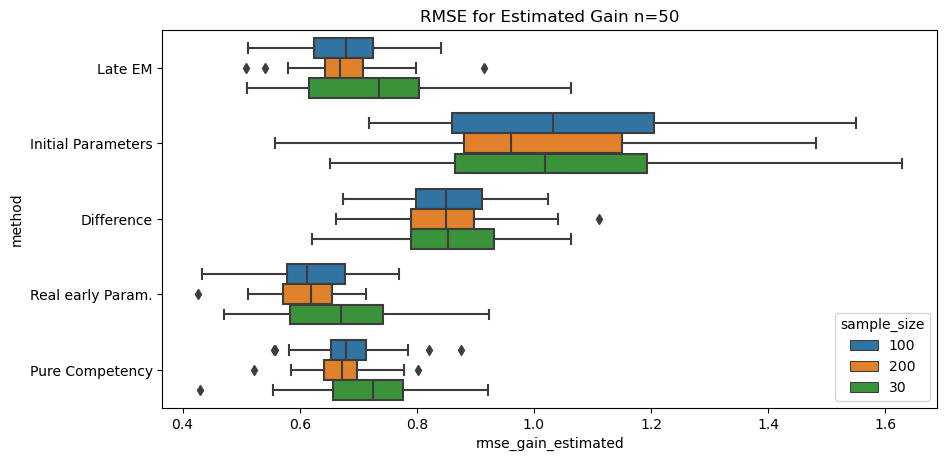

In [12]:
model_boxplot(full_Q_df, metric='rmse_gain_estimated', title="RMSE for Estimated Gain")

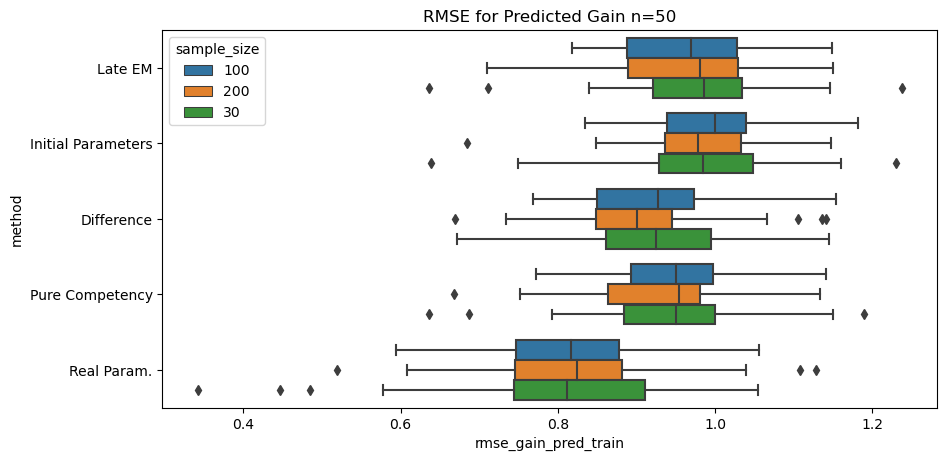

In [13]:
model_boxplot(full_Q_df, metric='rmse_gain_pred_train', title="RMSE for Predicted Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency"])

### Seperated Q-Matrix

In [14]:
parameter_table_model(sep_Q_df, caption="Seperated Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix, Reference Model, $n=45$}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.893 &       0.898 &       0.092 &  1.402 &       1.536 &       0.195 &   0.250 \\
    & \textbf{Initial Parameters} &  0.502 &       0.510 &       0.185 &  0.898 &       1.278 &       0.453 &   0.347 \\
    & \textbf{Late EM} &  0.876 &       0.872 &       0.100 &  1.893 &       1.742 &       0.188 &   0.353 \\
    & \textbf{Pure Competency} &  0.943 &       0.884 &       0.168 &  2.126 &       2.036 &       0.259 &   0.277 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  1.781 &       1.921 &       0.181 &   0.369 \\
\cline{1-9}
\multirow{5}{*}{

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3355651762.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          0.893       0.898       0.092  1.402   
            Initial Parameters  0.502       0.510       0.185  0.898   
            Late EM             0.876       0.872       0.100  1.893   
            Pure Competency     0.943       0.884       0.168  2.126   
            Real early Param.     NaN         NaN         NaN  1.781   
100         Difference          0.344       0.381       0.056  0.349   
            Initial Parameters  0.481       0.371       0.118  0.883   
            Late EM             0.329       0.384       0.055  0.403   
            Pure Competency     0.338       0.363       0.235  0.394   
            Real early Param.     NaN         NaN         NaN  0.387   
200         Difference          0.236       0.232       0.044  0.268   
            Initial Parameters  0.534       0.328       0.152  0.874   
            Late EM             0.227       0.225       0.046  0.290   
            Pure Competency     0.233       0.225       0.202  0.276   
            Real early Param.     NaN         NaN         NaN  0.263   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               1.536       0.195   0.250  
            Initial Parameters       1.278       0.453   0.347  
            Late EM                  1.742       0.188   0.353  
            Pure Competency          2.036       0.259   0.277  
            Real early Param.        1.921       0.181   0.369  
100         Difference               0.555       0.140   0.199  
            Initial Parameters       1.288       0.382   0.341  
            Late EM                  0.711       0.198   0.328  
            Pure Competency          0.840       0.255   0.260  
            Real early Param.        0.636       0.179   0.326  
200         Difference               0.305       0.146   0.220  
            Initial Parameters       1.208       0.366   0.334  
            Late EM                  0.756       0.195   0.299  
            Pure Competency          0.685       0.222   0.300  
            Real early Param.        0.546       0.179   0.296

In [15]:
single_metric_table(sep_Q_df, "rmse_psi", caption="Seperated Q-Matrix RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix RMSE for Correlations $\Psi$, $n=22$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.301 &  0.250 &  0.197 &  0.317 &  0.264 &  0.242 \\
    & \textbf{Initial Parameters} &  0.323 &  0.347 &  0.363 &  0.309 &  0.337 &  0.314 \\
    & \textbf{Late EM} &  0.250 &  0.353 &  0.256 &  0.318 &  0.355 &  0.352 \\
    & \textbf{Pure Competency} &  0.242 &  0.277 &  0.287 &  0.281 &  0.294 &  0.288 \\
    & \textbf{Real early Param.} &  0.264 &  0.369 &  0.266 &  0.332 &  0.362 &  0.360 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.243 &  0.199 &  0.166 &  0.300 &  0.227 &  0.188 \\
    & \textbf{Initial Param

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3054108605.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.301  0.250  0.197  0.317  0.264  0.242
    Initial Parameters  0.323  0.347  0.363  0.309  0.337  0.314
    Late EM             0.250  0.353  0.256  0.318  0.355  0.352
    Pure Competency     0.242  0.277  0.287  0.281  0.294  0.288
    Real early Param.   0.264  0.369  0.266  0.332  0.362  0.360
100 Difference          0.243  0.199  0.166  0.300  0.227  0.188
    Initial Parameters  0.333  0.341  0.313  0.333  0.351  0.340
    Late EM             0.303  0.328  0.295  0.316  0.325  0.335
    Pure Competency     0.260  0.260  0.252  0.306  0.311  0.304
    Real early Param.   0.301  0.326  0.324  0.353  0.365  0.330
200 Difference          0.295  0.220  0.146  0.290  0.220  0.179
    Initial Parameters  0.369  0.334  0.374  0.324  0.332  0.323
    Late EM             0.312  0.299  0.310  0.323  0.319  0.361
    Pure Competency     0.292  0.300  0.285  0.304  0.276  0.295
    Real early Param.   0.334  0.296  0.304  0.332  0.341  0.361

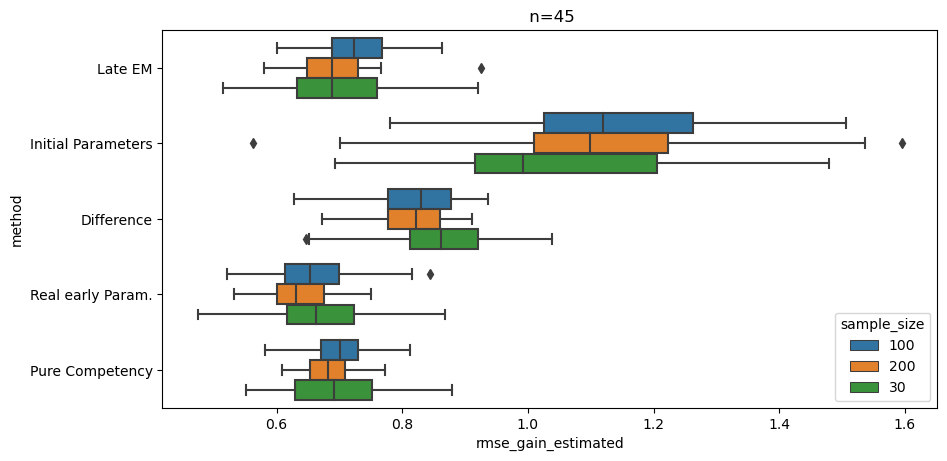

In [16]:
model_boxplot(sep_Q_df, metric='rmse_gain_estimated')

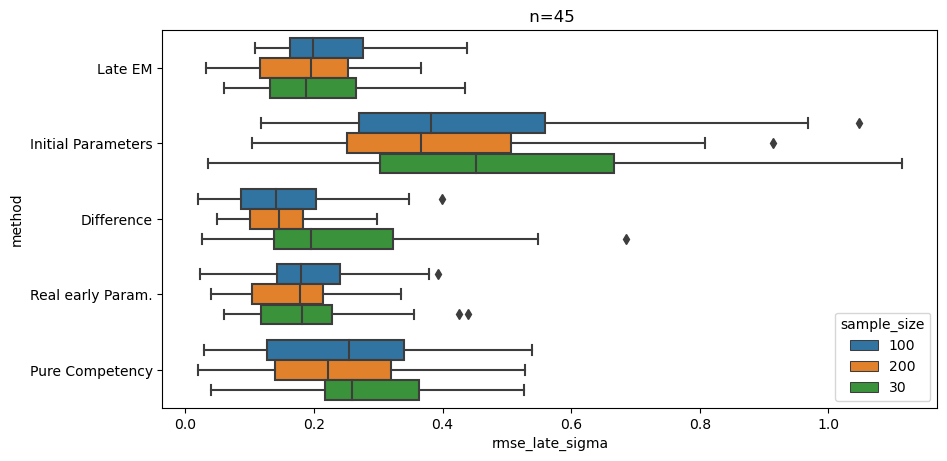

In [17]:
model_boxplot(sep_Q_df, metric='rmse_late_sigma')

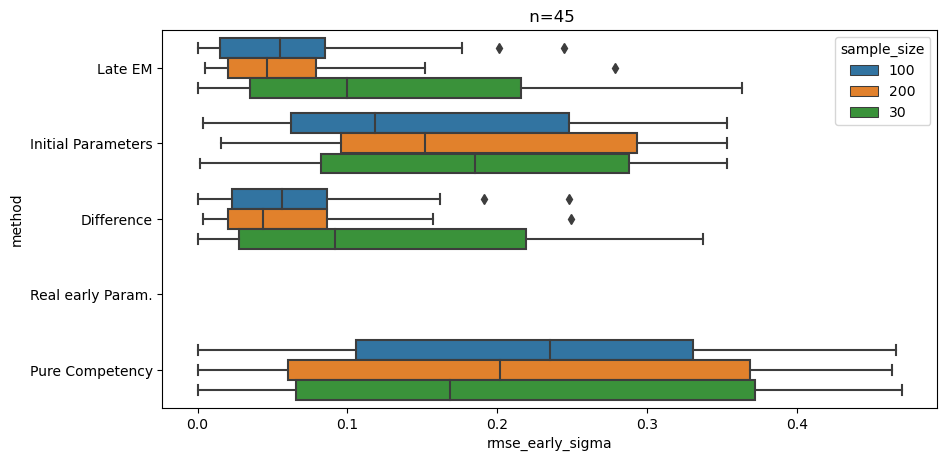

In [18]:
model_boxplot(sep_Q_df, metric='rmse_early_sigma')

### Pyramid Q-Matrix

In [19]:
parameter_table_model(full_Q_df, caption="Pyramid-Q-Matrix, RMSE Median of Parameter Recovery")

\begin{table}[H]
\centering
\caption{Pyramid-Q-Matrix, RMSE Median of Parameter Recovery, $n=50$}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  1.642 &       1.322 &       0.066 &  2.737 &       2.753 &       0.216 &   0.257 \\
    & \textbf{Initial Parameters} &  0.615 &       0.548 &       0.148 &  0.829 &       1.492 &       0.444 &   0.360 \\
    & \textbf{Late EM} &  1.598 &       1.351 &       0.065 &  4.655 &       4.171 &       0.225 &   0.317 \\
    & \textbf{Pure Competency} &  1.577 &       1.331 &       0.206 &  4.874 &       3.874 &       0.243 &   0.277 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  4.175 &       3.422 &       0.175 &   0.332 \\
\cline{1-9}


C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3355651762.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.642       1.322       0.066  2.737   
            Initial Parameters  0.615       0.548       0.148  0.829   
            Late EM             1.598       1.351       0.065  4.655   
            Pure Competency     1.577       1.331       0.206  4.874   
            Real early Param.     NaN         NaN         NaN  4.175   
100         Difference          0.465       0.393       0.055  0.555   
            Initial Parameters  0.662       0.435       0.156  0.857   
            Late EM             0.440       0.394       0.058  0.730   
            Pure Competency     0.438       0.386       0.198  0.672   
            Real early Param.     NaN         NaN         NaN  0.575   
200         Difference          0.320       0.250       0.067  0.421   
            Initial Parameters  0.627       0.387       0.156  0.878   
            Late EM             0.325       0.256       0.065  0.467   
            Pure Competency     0.325       0.257       0.198  0.440   
            Real early Param.     NaN         NaN         NaN  0.454   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.753       0.216   0.257  
            Initial Parameters       1.492       0.444   0.360  
            Late EM                  4.171       0.225   0.317  
            Pure Competency          3.874       0.243   0.277  
            Real early Param.        3.422       0.175   0.332  
100         Difference               0.691       0.151   0.218  
            Initial Parameters       1.405       0.388   0.351  
            Late EM                  0.781       0.186   0.306  
            Pure Competency          1.026       0.266   0.283  
            Real early Param.        0.721       0.182   0.284  
200         Difference               0.474       0.115   0.208  
            Initial Parameters       1.451       0.387   0.335  
            Late EM                  0.590       0.205   0.296  
            Pure Competency          0.693       0.275   0.260  
            Real early Param.        0.556       0.161   0.285

In [20]:
single_metric_table(pyramid_Q_df, "rmse_psi", caption="Pyramid Q-Matrix, Median RMSE for $\Psi$")

\begin{table}[H]
\centering
\caption{Pyramid Q-Matrix, Median RMSE for $\Psi$, $n=14$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.280 &  0.310 &  0.232 &  0.322 &  0.322 &  0.327 \\
    & \textbf{Initial Parameters} &  0.346 &  0.372 &  0.302 &  0.288 &  0.344 &  0.321 \\
    & \textbf{Late EM} &  0.277 &  0.292 &  0.294 &  0.296 &  0.337 &  0.279 \\
    & \textbf{Pure Competency} &  0.240 &  0.291 &  0.270 &  0.258 &  0.304 &  0.273 \\
    & \textbf{Real early Param.} &  0.288 &  0.312 &  0.286 &  0.320 &  0.362 &  0.315 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.296 &  0.218 &  0.228 &  0.319 &  0.293 &  0.276 \\
    & \textbf{Initial Parameters} 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3054108605.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.280  0.310  0.232  0.322  0.322  0.327
    Initial Parameters  0.346  0.372  0.302  0.288  0.344  0.321
    Late EM             0.277  0.292  0.294  0.296  0.337  0.279
    Pure Competency     0.240  0.291  0.270  0.258  0.304  0.273
    Real early Param.   0.288  0.312  0.286  0.320  0.362  0.315
100 Difference          0.296  0.218  0.228  0.319  0.293  0.276
    Initial Parameters  0.346  0.320  0.316  0.310  0.331  0.265
    Late EM             0.274  0.297  0.303  0.289  0.296  0.277
    Pure Competency     0.236  0.264  0.262  0.277  0.291  0.250
    Real early Param.   0.296  0.291  0.334  0.326  0.307  0.300
200 Difference          0.325  0.269  0.215  0.284  0.291  0.264
    Initial Parameters  0.350  0.288  0.301  0.297  0.346  0.315
    Late EM             0.304  0.266  0.215  0.288  0.314  0.288
    Pure Competency     0.290  0.238  0.267  0.265  0.303  0.279
    Real early Param.   0.386  0.300  0.233  0.333  0.347  0.327

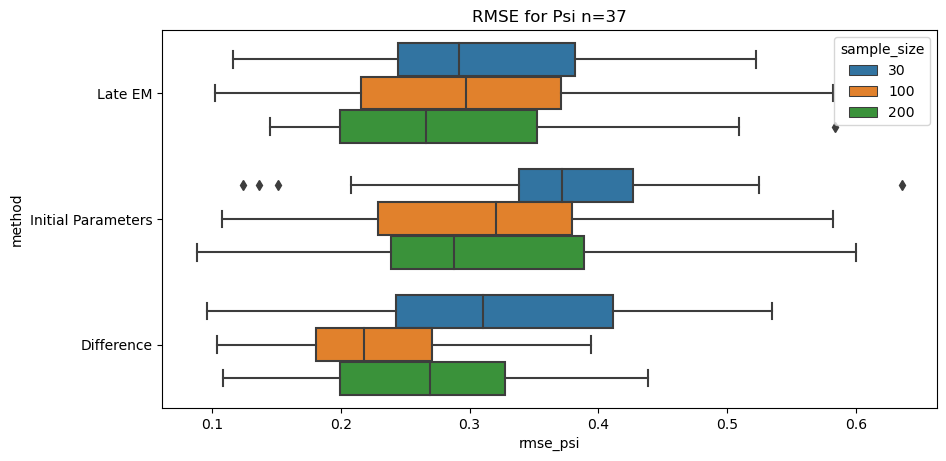

In [21]:
model_boxplot(pyramid_Q_df, metric="rmse_psi", methods=["late_em", "initial", "difference"], title="RMSE for Psi")

## Experiment 2: Prediction of Competency Gain

In [22]:
single_metric_table(full_Q_df, "rmse_theta", caption="Median RMSE for the estimation of $\\theta$",
                    methods=["late_em", "initial", "real_parameters", "pure_competency"])

\begin{table}[H]
\centering
\caption{Median RMSE for the estimation of $\theta$, $n=26$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{4}{*}{\textbf{30 }} & \textbf{Initial Parameters} &  0.591 &  0.512 &  0.454 &  0.669 &  0.576 &  0.526 \\
    & \textbf{Late EM} &  0.618 &  0.511 &  0.474 &  0.677 &  0.585 &  0.547 \\
    & \textbf{Pure Competency} &  0.639 &  0.515 &  0.492 &  0.698 &  0.592 &  0.559 \\
    & \textbf{Real Param.} &  0.546 &  0.459 &  0.410 &  0.616 &  0.503 &  0.471 \\
\cline{1-8}
\multirow{4}{*}{\textbf{100}} & \textbf{Initial Parameters} &  0.619 &  0.507 &  0.454 &  0.661 &  0.568 &  0.519 \\
    & \textbf{Late EM} &  0.601 &  0.490 &  0.433 &  0.655 &  0.544 &  0.488 \\
    & \textbf{Pure Competency} & 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3054108605.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Initial Parameters  0.591  0.512  0.454  0.669  0.576  0.526
    Late EM             0.618  0.511  0.474  0.677  0.585  0.547
    Pure Competency     0.639  0.515  0.492  0.698  0.592  0.559
    Real Param.         0.546  0.459  0.410  0.616  0.503  0.471
100 Initial Parameters  0.619  0.507  0.454  0.661  0.568  0.519
    Late EM             0.601  0.490  0.433  0.655  0.544  0.488
    Pure Competency     0.610  0.493  0.430  0.667  0.563  0.509
    Real Param.         0.578  0.474  0.406  0.623  0.519  0.471
200 Initial Parameters  0.603  0.503  0.445  0.665  0.566  0.512
    Late EM             0.590  0.472  0.422  0.654  0.532  0.477
    Pure Competency     0.597  0.480  0.430  0.667  0.545  0.488
    Real Param.         0.575  0.458  0.410  0.626  0.518  0.465

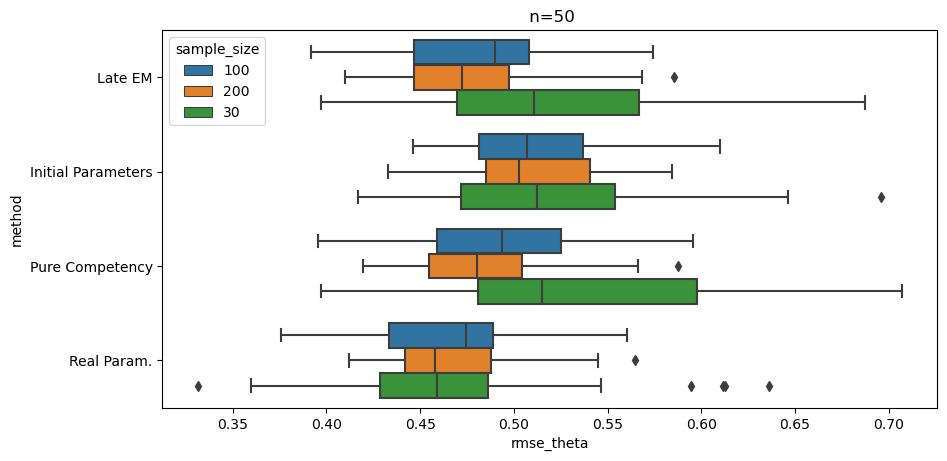

In [23]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial", "real_parameters", "pure_competency"], title="")
plt.savefig("results/plots/boxplot_full_Q_rmse_theta.png", bbox_inches="tight")

In [24]:
single_metric_table(full_Q_df, "rmse_gain_estimated", caption="Median RMSE for Competency Gain Estimation",
                        methods=["late_em", "initial", "difference", "real_early", "real_parameters", "pure_competency"])

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Estimation, $n=26$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.858 &  0.853 &  0.886 &  0.961 &  0.976 &  0.956 \\
    & \textbf{Initial Parameters} &  0.926 &  1.018 &  1.073 &  0.998 &  1.108 &  1.196 \\
    & \textbf{Late EM} &  0.759 &  0.736 &  0.655 &  0.856 &  0.763 &  0.713 \\
    & \textbf{Pure Competency} &  0.761 &  0.726 &  0.677 &  0.837 &  0.762 &  0.718 \\
    & \textbf{Real Param.} &  0.559 &  0.485 &  0.436 &  0.616 &  0.531 &  0.473 \\
    & \textbf{Real early Param.} &  0.749 &  0.671 &  0.623 &  0.822 &  0.737 &  0.679 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3054108605.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.858  0.853  0.886  0.961  0.976  0.956
    Initial Parameters  0.926  1.018  1.073  0.998  1.108  1.196
    Late EM             0.759  0.736  0.655  0.856  0.763  0.713
    Pure Competency     0.761  0.726  0.677  0.837  0.762  0.718
    Real Param.         0.559  0.485  0.436  0.616  0.531  0.473
    Real early Param.   0.749  0.671  0.623  0.822  0.737  0.679
100 Difference          0.888  0.849  0.841  0.930  0.960  0.935
    Initial Parameters  0.910  1.032  1.068  0.986  1.001  1.222
    Late EM             0.785  0.678  0.611  0.849  0.758  0.709
    Pure Competency     0.769  0.678  0.623  0.824  0.734  0.704
    Real Param.         0.563  0.479  0.438  0.609  0.529  0.482
    Real early Param.   0.735  0.613  0.550  0.821  0.732  0.665
200 Difference          0.850  0.850  0.862  0.943  0.929  0.935
    Initial Parameters  0.889  0.961  1.105  0.987  1.103  1.196
    Late EM             0.761  0.668  0.635  0.857  0.758  0.694
    Pure Competency     0.752  0.672  0.621  0.848  0.747  0.684
    Real Param.         0.567  0.507  0.444  0.613  0.531  0.477
    Real early Param.   0.732  0.619  0.576  0.840  0.718  0.650

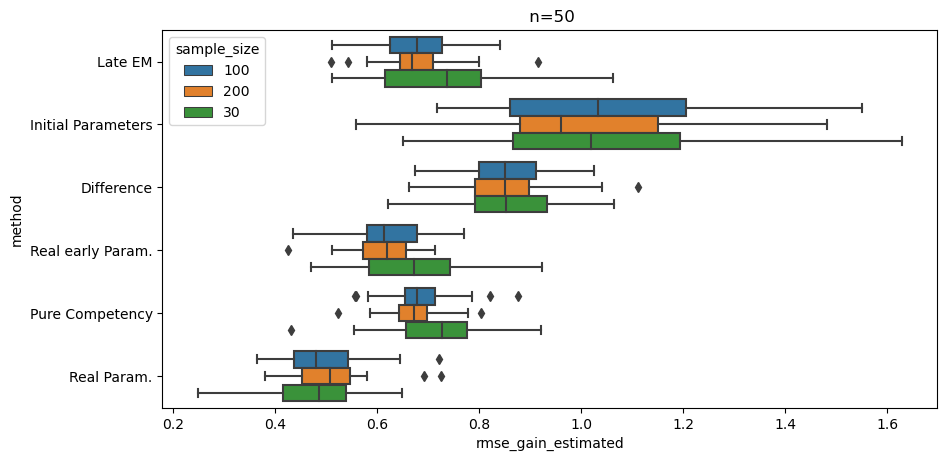

In [25]:
model_boxplot(full_Q_df, metric="rmse_gain_estimated", title="", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_estimated.png", bbox_inches="tight")

In [26]:
single_metric_table(full_Q_df, "rmse_gain_pred_train", caption="Median RMSE for Competency Gain Prediction",
                    methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Prediction, $n=26$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.938 &  0.925 &  0.894 &  1.035 &  0.992 &  0.966 \\
    & \textbf{Initial Parameters} &  0.968 &  0.984 &  0.957 &  1.025 &  1.036 &  1.046 \\
    & \textbf{Late EM} &  0.957 &  0.986 &  0.973 &  1.027 &  1.058 &  1.051 \\
    & \textbf{Pure Competency} &  0.939 &  0.951 &  0.924 &  1.000 &  0.995 &  1.020 \\
    & \textbf{Real Param.} &  0.808 &  0.812 &  0.792 &  0.856 &  0.840 &  0.851 \\
    & \textbf{Real early Param.} &  0.949 &  0.969 &  0.976 &  1.030 &  1.045 &  1.059 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.

C:\Users\Jesper\AppData\Local\Temp\ipykernel_20928\3054108605.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.938  0.925  0.894  1.035  0.992  0.966
    Initial Parameters  0.968  0.984  0.957  1.025  1.036  1.046
    Late EM             0.957  0.986  0.973  1.027  1.058  1.051
    Pure Competency     0.939  0.951  0.924  1.000  0.995  1.020
    Real Param.         0.808  0.812  0.792  0.856  0.840  0.851
    Real early Param.   0.949  0.969  0.976  1.030  1.045  1.059
100 Difference          0.932  0.928  0.879  1.018  1.000  0.949
    Initial Parameters  0.988  1.000  0.975  1.038  1.053  1.061
    Late EM             0.956  0.969  0.962  1.028  1.063  1.041
    Pure Competency     0.943  0.950  0.935  1.010  1.035  1.021
    Real Param.         0.845  0.816  0.824  0.852  0.868  0.845
    Real early Param.   0.970  0.950  0.950  1.039  1.085  1.028
200 Difference          0.918  0.900  0.864  1.044  0.989  0.933
    Initial Parameters  0.965  0.978  0.966  1.066  1.045  1.064
    Late EM             0.955  0.981  0.943  1.061  1.058  1.067
    Pure Competency     0.923  0.955  0.922  1.052  1.022  1.018
    Real Param.         0.785  0.824  0.801  0.882  0.854  0.851
    Real early Param.   0.964  0.953  0.908  1.076  1.074  1.085

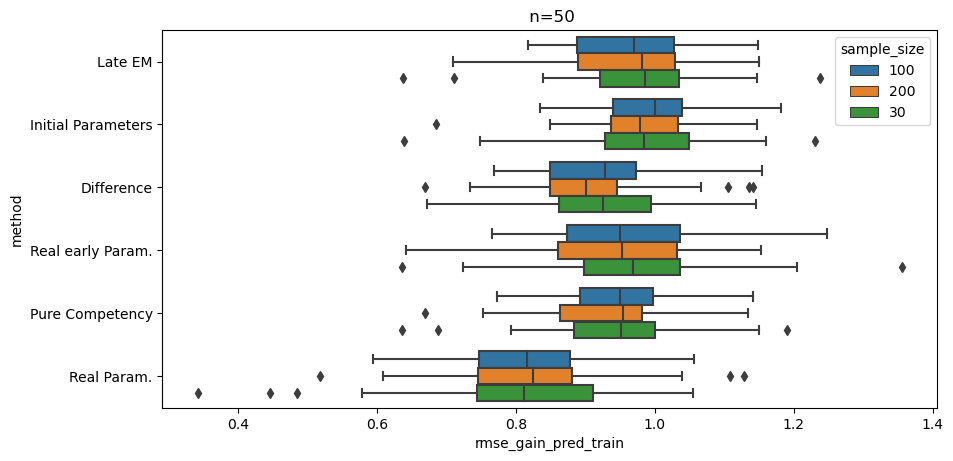

In [27]:
model_boxplot(full_Q_df, metric="rmse_gain_pred_train", title="",
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_predicted.png", bbox_inches="tight")

In [28]:
np.random.exponential(scale=0.5, size=10) + 1

array([1.39063045, 4.63747797, 1.17050167, 1.31786405, 2.20626095,
       1.155816  , 1.11884304, 1.66847901, 1.1722499 , 1.35341835])

## CSEDM Data
base: uirt_lfa_model_csedm_final.ipynb

### Read in and preprocess data

In [29]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [30]:
semester = 'F19'
BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [31]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

In [32]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [33]:
V

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
363,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [34]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [35]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]
# Ensure Identification
late_Q[2,1] = False

In [36]:
late_Q

array([[False,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [False,  True]])

### Fit Model

In [37]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.4313]
 [0.4313 1.    ]]
Step: 2: current parameter_diff: 8.037365811608, current marginal loglikelihood: -5624.736443741475
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.    0.352]
 [0.352 1.   ]]
Step: 3: current parameter_diff: 4.687642661389493, current marginal loglikelihood: -5601.065169480491
EM Iteration 4
Current Monte Carlo Sample size: 349
[[0.9999 0.3043]
 [0.3043 1.    ]]
Step: 4: current parameter_diff: 2.3228633805310794, current marginal loglikelihood: -5589.219822980704
EM Iteration 5
Current Monte Carlo Sample size: 349
[[0.9999 0.2799]
 [0.2799 1.    ]]
Step: 5: current parameter_diff: 2.173022712275473, current marginal loglikelihood: -5579.470445220899
EM Iteration 6
Current Monte Carlo Sample size: 376
[[1.     0.2871]
 [0.2871 1.    ]]
Step: 6: current parameter_diff: 1.1959832791106868, current marginal loglikelihood: -5582.006781862318
EM Iteration 7


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 406
[[0.9999 0.2939]
 [0.2939 1.    ]]
Step: 7: current parameter_diff: 1.1466856034678126, current marginal loglikelihood: -5578.906328682199
EM Iteration 8
Current Monte Carlo Sample size: 438
[[1.     0.2955]
 [0.2955 1.    ]]
Step: 8: current parameter_diff: 1.6610997898300628, current marginal loglikelihood: -5579.814733177544


In [38]:
p_early = np.mean(U, axis=1)
p_late = np.mean(V, axis=1)
# Correct numerical problems with the inverse logistic function
p_early[p_early == 0] = np.min(p_early[p_early != 0])
p_early[p_early == 1] = np.max(p_early[p_early != 1])
p_late[p_late == 0] = np.min(p_late[p_late != 0])
p_late[p_late == 1] = np.max(p_late[p_late != 1])
# get logits
logit_early = np.log(np.divide(p_early, 1 -
                                p_early))
logit_late = np.log(np.divide(p_late, 1 -
                                p_late))
var_logit_early = np.var(logit_early)
var_logit_late = np.var(logit_late)

#
print("Early logit variance: {0}".format(var_logit_early))
print("Late logit variance: {0}".format(var_logit_late))
print("Approximate convolution variance: {0}".format(var_logit_late/var_logit_early))

Early logit variance: 1.2907867467786318
Late logit variance: 1.790658381505874
Approximate convolution variance: 1.3872612079220314


In [39]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=np.zeros(2),
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.005, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2
Current Monte Carlo Sample size: 300
[[1.     0.2955 0.1373 0.0707]
 [0.2955 1.     0.0709 0.1418]
 [0.1373 0.0709 0.3567 0.0966]
 [0.0707 0.1418 0.0966 0.343 ]]
Step: 2: current parameter_diff: 11.75135713693369, current marginal loglikelihood: -4261.019858938647
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.2955 0.1368 0.0765]
 [0.2955 1.     0.076  0.1467]
 [0.1368 0.076  0.3625 0.1   ]
 [0.0765 0.1467 0.1    0.3433]]
Step: 3: current parameter_diff: 5.587208796570338, current marginal loglikelihood: -4264.2391722032535
EM Iteration 4


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[1.     0.2955 0.14   0.0778]
 [0.2955 1.     0.0772 0.1457]
 [0.14   0.0772 0.3591 0.102 ]
 [0.0778 0.1457 0.102  0.3452]]
Step: 4: current parameter_diff: 3.591259785664278, current marginal loglikelihood: -4251.226401049423
EM Iteration 5


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[1.     0.2955 0.1386 0.0769]
 [0.2955 1.     0.0752 0.1447]
 [0.1386 0.0752 0.362  0.1012]
 [0.0769 0.1447 0.1012 0.3462]]
Step: 5: current parameter_diff: 2.820418875971843, current marginal loglikelihood: -4238.195329903451


In [41]:
# Fit late difference model
late_difference_model = mirt_2pl(latent_dimension=2, item_dimension=V.shape[1], Q=late_Q)
late_difference_model.initialize_from_responses(response_data=V)
e_step_diff = e_step_ga_mml(model=late_difference_model)
m_step_diff = m_step_ga_mml(
    late_difference_model, sigma_constraint="early_constraint")
em_diff = em_algo(e_step=e_step_diff, m_step=m_step_diff, model=late_difference_model)


start_time = time.time()
em_diff.fit([V.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(V)
estimated_early_item_parameters = em_diff.model.item_parameters
estimated_early_person_parameters = em_diff.model.person_parameters

# Estimate early parameters with standard-procedure

# Shift Discriminations and Covariance accoring to real variance
conv_sigma = late_model.person_parameters["covariance"]
conv_A = late_model.item_parameters["discrimination_matrix"]
real_conv_sigma_var = var_logit_late/var_logit_early*np.ones(2)
conv_sd_vector = np.sqrt(real_conv_sigma_var)
conv_sd_matrix = np.diag(conv_sd_vector)
conv_sigma_scaled = np.round(np.dot(
    np.dot(conv_sd_matrix, conv_sigma), conv_sd_matrix), 5)
conv_A_scaled = np.dot(conv_A, np.linalg.inv(conv_sd_matrix).transpose())
scaled_parameters = {"person_parameters": {"covariance": conv_sigma_scaled},
                        "item_parameters": {"discrimination_matrix": conv_A_scaled}}
late_model.set_parameters(scaled_parameters)

late_theta_hat = late_model.predict_competency(
    sample["late_responses"], strict_variance=False) + gain_mean
# Double late theta because var(late_theta) = var(early_theta + gain) = var(early_theta) + var(gain) - 2*cov(early_theta, gain)
s_hat = late_theta_hat - early_theta_hat
late_estimated_parameters["item_parameters"]["discrimination_matrix"] = conv_A_scaled
late_delta = late_estimated_parameters["item_parameters"]["intercept_vector"]
translated_delta = late_delta - \
    np.dot(late_estimated_parameters["item_parameters"]
            ["discrimination_matrix"], np.ones(D))
late_estimated_parameters["item_parameters"]["intercept_vector"] = translated_delta
sigma_psi = pd.DataFrame(np.concatenate(
    (early_theta_hat, s_hat), axis=1)).cov().to_numpy()
late_estimated_parameters["person_parameters"]["covariance"] = sigma_psi

######################
item_dimension = parameter_dict["item_dimension"]
actual_late_model = mirt_2pl_gain(item_dimension=item_dimension, latent_dimension=D,
                                    mu=gain_mean,
                                    early_sigma=early_estimated_parameters["person_parameters"]["covariance"],
                                    Q=parameter_dict["real_late_parameters"]["item_parameters"]["q_matrix"])

EM Iteration 2


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.4979]
 [0.4979 0.9999]]
Step: 2: current parameter_diff: 7.2392616142424675, current marginal loglikelihood: -3464.2595662669296
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.5087]
 [0.5087 1.    ]]
Step: 3: current parameter_diff: 6.134699816281302, current marginal loglikelihood: -3448.533187829244
EM Iteration 4


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[0.9999 0.5037]
 [0.5037 1.    ]]
Step: 4: current parameter_diff: 3.5610476415769448, current marginal loglikelihood: -3428.8192855091875
EM Iteration 5


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[1.     0.4776]
 [0.4776 1.    ]]
Step: 5: current parameter_diff: 2.277489280884767, current marginal loglikelihood: -3415.8277579992655
EM Iteration 6


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 406
[[1.    0.456]
 [0.456 1.   ]]
Step: 6: current parameter_diff: 2.015489628243438, current marginal loglikelihood: -3407.204691556236
EM Iteration 7


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 438
[[1.     0.4489]
 [0.4489 1.    ]]
Step: 7: current parameter_diff: 0.6342784501383162, current marginal loglikelihood: -3409.2832522792887
EM Iteration 8


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 473
[[0.9999 0.4472]
 [0.4472 0.9999]]
Step: 8: current parameter_diff: 0.6185127807308769, current marginal loglikelihood: -3408.323910228781
EM Iteration 9


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 510
[[1.     0.4422]
 [0.4422 1.    ]]
Step: 9: current parameter_diff: 1.1774024479325893, current marginal loglikelihood: -3403.541024678333
EM Iteration 10
Current Monte Carlo Sample size: 550
[[1.     0.4352]
 [0.4352 1.    ]]
Step: 10: current parameter_diff: 0.4035219075282497, current marginal loglikelihood: -3401.665748266916
EM Iteration 11


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 594
[[0.9999 0.4316]
 [0.4316 1.    ]]
Step: 11: current parameter_diff: 1.4569424461397422, current marginal loglikelihood: -3401.759806114724
EM Iteration 12
Current Monte Carlo Sample size: 641
[[1.     0.432 ]
 [0.432  0.9999]]
Step: 12: current parameter_diff: 0.22481785938023158, current marginal loglikelihood: -3397.8095835526183
EM Iteration 13
Current Monte Carlo Sample size: 641
[[0.9999 0.4297]
 [0.4297 1.    ]]
Step: 13: current parameter_diff: 0.43443707169244516, current marginal loglikelihood: -3402.6931876881517
EM Iteration 14
Current Monte Carlo Sample size: 692
[[0.9999 0.4322]
 [0.4322 0.9999]]
Step: 14: current parameter_diff: 0.9032819438764855, current marginal loglikelihood: -3399.4540829719726
EM Iteration 15


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 747
[[1.     0.4269]
 [0.4269 0.9999]]
Step: 15: current parameter_diff: 0.4318375002855732, current marginal loglikelihood: -3397.5595955106087
EM Iteration 16
Current Monte Carlo Sample size: 806
[[1.     0.4236]
 [0.4236 1.    ]]
Step: 16: current parameter_diff: 0.6819607276842895, current marginal loglikelihood: -3395.946009464732


ValueError: shapes (20,) and (30,) not aligned: 20 (dim 0) != 30 (dim 0)

### Analyse Results 

#### Item Parameters

In [52]:
#Item Parameters 

# Early 
early_A = early_model.item_parameters["discrimination_matrix"]
early_delta = early_model.item_parameters["intercept_vector"]
early_Q = early_model.item_parameters["q_matrix"]

# Late
late_A = late_model.item_parameters["discrimination_matrix"]
late_delta = late_model.item_parameters["intercept_vector"]
late_Q = late_model.item_parameters["q_matrix"]

In [53]:
def rel_test_difficulty(A, delta):
    rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)
    rel_item_difficulty[np.isinf(rel_item_difficulty)] = np.nan
    rel_test_difficulty = np.nanmean(rel_item_difficulty, axis=0)
    return(rel_test_difficulty)


def shift_table(s_hat, A, delta, early_reldiff):
    quantiles = np.arange(0, 0.5, 0.01)
    # mu_logic = []
    # mu_iter = []
    perc_pos_logic =[]
    perc_pos_iter = []
    logic_reldiff = []
    iter_reldiff = []
    for quantile in quantiles:
        shift = -1*np.quantile(s_hat, q=quantile, axis=0)
        delta_shift = late_delta - np.dot(late_A, shift)
        s_shift = s_hat + shift
        perc_positive = np.divide(np.sum(s_shift >= 0, axis=0), np.sum(s_shift == s_shift, axis=0))
        perc_pos_logic.append(perc_positive[0])
        perc_pos_iter.append(perc_positive[1])
        # mu_shift = np.mean(s_shift, axis=0)
        # mu_logic.append(mu_shift[0])
        #mu_iter.append(mu_shift[1])
        rel_test_diff = rel_test_difficulty(A=A, delta=delta_shift)
        logic_reldiff.append(rel_test_diff[0])
        iter_reldiff.append(rel_test_diff[1])
    # Create just a figure and only one subplot
    #fig, ax = plt.subplots()
    #ax.plot(x, y)
    #ax.set_title('Simple plot')
# Create two subplots and unpack the output array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(10)
    f.suptitle("Share of students with Competency \n Gain vs. Relative Test Difficulty", fontsize=14, y=1.05)
    ax1.plot(perc_pos_logic, logic_reldiff)
    ax1.plot(perc_pos_logic, [early_reldiff[0] for i in range(0, len(perc_pos_iter))])
    ax1.set_title("Logic Competency")
    ax2.plot(perc_pos_iter, iter_reldiff)
    ax2.plot(perc_pos_iter, [early_reldiff[1] for i in range(0, len(perc_pos_iter))])
    ax2.set_title("Iteration Competency")
    ax1.set_ylabel("Relative Difficulty")
    ax1.set_xlabel("Share of Gain")
    ax2.set_xlabel("Share of Gain")
    plt.legend(["Late Difficulty", "Early Difficulty"])
    #f.title("Share of students with Competency \n Gain vs. Relative Test Difficulty")

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\2073873220.py:2: RuntimeWarning: divide by zero encountered in true_divide
  rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)


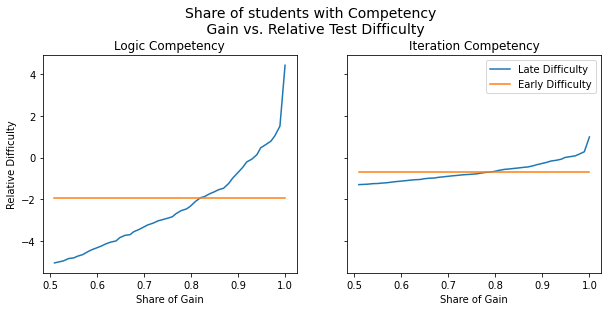

In [54]:
early_reldiff = rel_test_difficulty(A=early_A, delta=early_delta)
shift_table(s_hat=s_hat, A=late_A, delta=late_delta, early_reldiff=early_reldiff)
plt.savefig("results/plots/csedm_reldiff_vs_shift", dpi=200)

In [55]:
shift = np.zeros(2)
#Logic shift
shift[0] = -1*np.quantile(s_hat[:,0], q=0.2, axis=0)
#Iteration shift
shift[1] = -1*np.quantile(s_hat[:,1], q=0.05, axis=0)
s_hat_shift = s_hat + shift
mu_shift = late_model.person_parameters["mean"][2:4] + shift
late_delta_shift = late_delta - np.dot(late_A, shift)

In [56]:
#Check shift results
np.divide(np.sum(s_hat_shift >= 0, axis=0), np.sum(s_hat_shift == s_hat_shift, axis=0))

array([0.79836512, 0.94822888])

In [57]:
def item_parameter_table(A, Q, delta, latent_description=["Logic", "Iteration"], caption="", n=367):
    data = pd.DataFrame(np.concatenate((Q, A), axis=1))
    data.columns = pd.MultiIndex.from_product([['Q', 'A'], latent_description],
                                     names=['Param.', 'Latent dim.'])
    delta_df = pd.DataFrame(np.expand_dims(delta, 1), columns=[("$\Delta$", "")])
    data = pd.concat((data, delta_df), axis=1)
    data = np.round(data, 3)
    print(data.to_latex(bold_rows=True, multicolumn=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(data)

In [58]:
item_parameter_table(A=early_A, Q=early_Q, delta=early_delta, caption="CSEDM: Early Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Early Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   1.0 &       0.0 &  0.901 &     0.000 &    1.716 \\
\textbf{1 } &   1.0 &       0.0 &  1.323 &     0.000 &    1.359 \\
\textbf{2 } &   1.0 &       0.0 &  0.913 &     0.000 &    1.276 \\
\textbf{3 } &   1.0 &       0.0 &  0.838 &     0.000 &    1.345 \\
\textbf{4 } &   1.0 &       0.0 &  1.179 &     0.000 &    1.309 \\
\textbf{5 } &   1.0 &       0.0 &  1.326 &     0.000 &    1.442 \\
\textbf{6 } &   1.0 &       0.0 &  0.951 &     0.000 &    1.140 \\
\textbf{7 } &   1.0 &       0.0 &  0.877 &     0.000 &    1.297 \\
\textbf{8 } &   1.0 &       0.0 &  1.051 &     0.000 &    1.208 \\
\textbf{9 } &   1.0 &       0.0 &  1.305 &     0.000 &    1.235 \\
\textbf{10} &   1.0 &       0.0 &  1.122 &     0.00

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             1.0       0.0  0.901     0.000    1.716
1             1.0       0.0  1.323     0.000    1.359
2             1.0       0.0  0.913     0.000    1.276
3             1.0       0.0  0.838     0.000    1.345
4             1.0       0.0  1.179     0.000    1.309
5             1.0       0.0  1.326     0.000    1.442
6             1.0       0.0  0.951     0.000    1.140
7             1.0       0.0  0.877     0.000    1.297
8             1.0       0.0  1.051     0.000    1.208
9             1.0       0.0  1.305     0.000    1.235
10            1.0       0.0  1.122     0.000    1.487
11            1.0       0.0  1.132     0.000    1.562
12            1.0       0.0  1.228     0.000    1.575
13            1.0       0.0  1.345     0.000    1.474
14            1.0       0.0  1.140     0.000    1.169
15            1.0       0.0  1.179     0.000    0.801
16            1.0       0.0  1.072     0.000    1.153
17            1.0       0.0  0.995     0.000    1.190
18            1.0       1.0  1.000     0.884    0.270
19            1.0       0.0  0.874     0.000    0.609
20            0.0       1.0  0.000     2.496    1.580
21            1.0       1.0  0.068     2.428    1.154
22            1.0       1.0  0.220     1.678    1.173
23            1.0       1.0  0.529     1.731    1.197
24            1.0       1.0  1.056     1.455    1.566
25            1.0       0.0  0.903     0.000    1.075
26            1.0       1.0  0.538     1.419    0.547
27            1.0       1.0  0.869     1.379    1.224
28            1.0       1.0  0.891     0.776    1.036
29            1.0       1.0  0.560     1.668    0.995

In [59]:
item_parameter_table(A=late_A, Q=late_Q, delta=late_delta_shift, caption="CSEDM: Late Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Late Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   0.0 &       1.0 &  0.000 &     0.517 &    0.884 \\
\textbf{1 } &   1.0 &       1.0 &  1.000 &     1.000 &    0.398 \\
\textbf{2 } &   1.0 &       0.0 &  1.262 &     0.000 &    1.575 \\
\textbf{3 } &   1.0 &       1.0 &  0.811 &     1.451 &   -0.083 \\
\textbf{4 } &   1.0 &       1.0 &  1.079 &     0.616 &    0.340 \\
\textbf{5 } &   1.0 &       1.0 &  0.666 &     0.830 &    0.279 \\
\textbf{6 } &   1.0 &       1.0 &  0.661 &     0.836 &    0.172 \\
\textbf{7 } &   1.0 &       1.0 &  0.495 &     1.241 &   -0.100 \\
\textbf{8 } &   1.0 &       1.0 &  0.792 &     2.211 &   -0.728 \\
\textbf{9 } &   1.0 &       1.0 &  0.206 &     1.261 &   -0.553 \\
\textbf{10} &   1.0 &       1.0 &  1.000 &     1.131

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             0.0       1.0  0.000     0.517    0.884
1             1.0       1.0  1.000     1.000    0.398
2             1.0       0.0  1.262     0.000    1.575
3             1.0       1.0  0.811     1.451   -0.083
4             1.0       1.0  1.079     0.616    0.340
5             1.0       1.0  0.666     0.830    0.279
6             1.0       1.0  0.661     0.836    0.172
7             1.0       1.0  0.495     1.241   -0.100
8             1.0       1.0  0.792     2.211   -0.728
9             1.0       1.0  0.206     1.261   -0.553
10            1.0       1.0  1.000     1.131    0.060
11            1.0       1.0  0.352     2.001    0.140
12            1.0       1.0  0.341     1.377   -0.337
13            1.0       1.0  0.382     1.244    0.235
14            0.0       1.0  0.000     1.078    0.948
15            1.0       1.0  0.047     1.918    0.037
16            1.0       1.0  0.629     1.653   -0.965
17            1.0       1.0  0.456     1.098    0.132
18            0.0       1.0  0.000     1.784   -0.136
19            0.0       1.0  0.000     1.498    0.255

(array([[  2.,  18.,  55., 125., 151.,  16.,   0.,   0.,   0.,   0.],
        [  0.,   2.,  17.,  35.,  64.,  86., 119.,  34.,   7.,   3.]]),
 array([-1.08155124, -0.71913464, -0.35671804,  0.00569856,  0.36811515,
         0.73053175,  1.09294835,  1.45536495,  1.81778155,  2.18019814,
         2.54261474]),
 <a list of 2 BarContainer objects>)

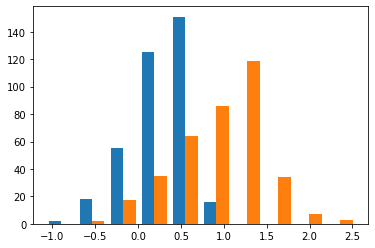

In [60]:
plt.hist(s_hat_shift)

#### Person Parameters

In [61]:
#early
early_covariance = early_model.person_parameters["covariance"]
early_mu = np.zeros(2)

#late
late_covariance = late_model.person_parameters["covariance"]
late_mu = np.concatenate((early_mu, mu_shift), axis=0)

In [62]:
def table_person_parameters(covariance, mu, latent_description=["Logic", "Iteration"], caption="", n=367):
    cov_df = pd.DataFrame(covariance)
    index = pd.MultiIndex.from_product([['Prior Competence', 'Competence Gain'], latent_description],
                        names=['Param.', 'Latent dim.'])
    cov_df.columns = index
    mu_df = pd.DataFrame(np.expand_dims(mu, axis=1), columns=[("Mean", "")])
    person_df = pd.concat((cov_df, mu_df), axis=1)
    person_df.index = index
    person_df = np.round(person_df, 3)
    print(person_df.to_latex(bold_rows=True, multicolumn=True, 
                                caption=caption+", n={0}".format(n), 
                                position="H", escape=False))
    return(person_df)
    

In [63]:
table_person_parameters(covariance=late_covariance, mu=late_mu, caption="CSEDM: Person Parameters")
# TODO: Evtl. Korrelationsmatrix mit Varianz-Spalte

\begin{table}[H]
\centering
\caption{CSEDM: Person Parameters, n=367}
\begin{tabular}{llrrrrr}
\toprule
                & \textbf{Param.} & \multicolumn{2}{l}{Prior Competence} & \multicolumn{2}{l}{Competence Gain} &   Mean \\
                & \textbf{Latent dim.} &            Logic & Iteration &           Logic & \multicolumn{2}{l}{Iteration} \\
\textbf{Param.} & \textbf{Latent dim.} &                  &           &                 &           &        \\
\midrule
\textbf{Prior Competence} & \textbf{Logic} &            1.000 &     0.242 &           0.139 &     0.070 &  0.000 \\
                & \textbf{Iteration} &            0.242 &     1.000 &           0.064 &     0.146 &  0.000 \\
\textbf{Competence Gain} & \textbf{Logic} &            0.139 &     0.064 &           0.357 &     0.090 &  0.239 \\
                & \textbf{Iteration} &            0.070 &     0.146 &           0.090 &     0.346 &  0.913 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\Jesper\AppData\Local\Temp\ipykernel_21064\1204287124.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(person_df.to_latex(bold_rows=True, multicolumn=True,


Param.                       Prior Competence           Competence Gain  \
Latent dim.                             Logic Iteration           Logic   
Param.           Latent dim.                                              
Prior Competence Logic                  1.000     0.242           0.139   
                 Iteration              0.242     1.000           0.064   
Competence Gain  Logic                  0.139     0.064           0.357   
                 Iteration              0.070     0.146           0.090   

Param.                                   Mean  
Latent dim.                  Iteration         
Param.           Latent dim.                   
Prior Competence Logic           0.070  0.000  
                 Iteration       0.146  0.000  
Competence Gain  Logic           0.090  0.239  
                 Iteration       0.346  0.913

#### Gain Visualization

In [51]:
def quantile_mean(df, metric, quantiles=[0.25, 0.5, 0.75, 1]):
    mean_df = pd.DataFrame()
    metric_quantiles = np.quantile(df[metric], quantiles)
    for quantile in metric_quantiles:
        quantile_df = df[df[metric] < quantile]
        df = df[df[metric] >= quantile]
        mean_df = pd.concat((mean_df, pd.DataFrame(quantile_df.mean()).transpose()), axis=0)
    mean_df.index = quantiles
    return(mean_df)

In [125]:
latent_df_csedm = pd.DataFrame(np.concatenate((theta_hat, s_hat_shift), axis=1))
latent_df_csedm.columns = ["prior logic", "prior iter", "logic gain", "iter gain"]

In [126]:
logic_quantile_mean = quantile_mean(latent_df_csedm, metric="prior logic")
logic_quantile_mean["post logic"] = logic_quantile_mean["prior logic"] + logic_quantile_mean["logic gain"]
logic_quantile_mean["post iter"] = logic_quantile_mean["prior iter"] + logic_quantile_mean["iter gain"]
np.round(logic_quantile_mean, 2)

,prior logic,prior iter,logic gain,iter gain,post logic,post iter
0.25,-0.95,-0.31,0.25,1.06,-0.70,0.75
0.50,-0.20,-0.04,0.18,0.88,-0.02,0.84
0.75,0.34,-0.05,0.20,0.91,0.53,0.86
1.00,1.11,0.44,0.26,0.95,1.37,1.38


In [127]:
logic_quantiles = np.quantile(theta_hat[:,0], [0.25, 0.5, 0.75, 1], axis=0)
iter_quantiles = np.quantile(theta_hat[:,1], [0.25, 0.5, 0.75, 1], axis=0)

In [128]:
theta_logic_quantiles = np.split(theta_hat[np.argsort(theta_hat[:,0]), :], [10, 20])

## Test Set prediction

In [46]:
TEST_PATH = os.path.join("C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset/F19_Release_Test_06-28-21/test")

test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

#test_subject_df = make_subject_df(early_test)
#test_subject_df = test_subject_df.drop("PercAltLabelTrue", 1)

#Obtain Matrix of Response-vectors
test_U = pd.crosstab(index = early_test["SubjectID"], 
            columns=[early_test["AssignmentID"], early_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")